# Importing Libraries

- This cell imports all required libraries for the project.
- NumPy is used for numerical operations, PyTorch is used to build and train the CNN model, and sklearn is used for evaluation metrics like accuracy and F1-score.

In [ ]:
import os, random
from glob import glob
from PIL import Image, UnidentifiedImageError

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm

# Mount Drive

Mount Google Drive to access the dataset stored in Drive.

This allows the notebook to read images directly from the shared folder.

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting Dataset Path

Define paths to training, validation, and test datasets.

Keeping paths separate ensures proper evaluation and avoids data leakage.

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Dataset/Discriminative Project Milstone_1"
assert os.path.exists(DATA_DIR), "Dataset path not found"

#Setting up for Model Training

CPU Device + Seed

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Transforms (CPU friendly)

Define image transformations applied before feeding images to the model.

These include resizing, normalization, and data augmentation to improve generalization and reduce overfitting.

In [ ]:
IMG_SIZE = 160  # smaller than 224 to speed up CPU

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(0.12,0.12,0.12),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# Splitting the datasets

Dataset + Stratified Split (70/15/15)

In [ ]:
full_ds = datasets.ImageFolder(DATA_DIR, transform=eval_tfms)
num_classes = len(full_ds.classes)
print("Classes:", num_classes, full_ds.classes)

labels = np.array([y for _, y in full_ds.samples])

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(sss1.split(np.zeros(len(labels)), labels))

temp_labels = labels[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_rel, test_rel = next(sss2.split(np.zeros(len(temp_labels)), temp_labels))

val_idx = temp_idx[val_rel]
test_idx = temp_idx[test_rel]

train_ds = datasets.ImageFolder(DATA_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(DATA_DIR, transform=eval_tfms)
test_ds  = datasets.ImageFolder(DATA_DIR, transform=eval_tfms)

train_set = Subset(train_ds, train_idx)
val_set   = Subset(val_ds, val_idx)
test_set  = Subset(test_ds, test_idx)

print("Train / Val / Test:", len(train_set), len(val_set), len(test_set))

Classes: 39 ['IMAGES_OBJ786', 'IMAGES_OBJ788', 'IMAGES_OBJ789', 'Images_OBJ069', 'image_OBJ007', 'image_OBJ027', 'image_OBJ090', 'image_OBJ787', 'images_OBJ001', 'images_OBJ002', 'images_OBJ003', 'images_OBJ004', 'images_OBJ005', 'images_OBJ006', 'images_OBJ008', 'images_OBJ009', 'images_OBJ010', 'images_OBJ012', 'images_OBJ016', 'images_OBJ018', 'images_OBJ019', 'images_OBJ021', 'images_OBJ022', 'images_OBJ028', 'images_OBJ029', 'images_OBJ031', 'images_OBJ061', 'images_OBJ095', 'images_OBJ107', 'images_OBJ108', 'images_OBJ111', 'images_OBJ159', 'images_OBJ208', 'images_OBJ222', 'images_OBJ229', 'images_OBJ230', 'images_OBJ311', 'images_OBJ405', 'images_OBJ_300']
Train / Val / Test: 2875 616 617


# DataLoaders

Create PyTorch datasets and dataloaders.

Dataloaders handle batching, shuffling, and parallel data loading during training and evaluation.

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2  # keep small for CPU

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Dataloaders ready.")

Dataloaders ready.


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
print("Truncated image handling enabled.")

Truncated image handling enabled.


# Models

CNN model extracts spatial features using convolutional layers and performs classification using fully connected layers.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        feat = 256 * (IMG_SIZE//16) * (IMG_SIZE//16)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

print("SimpleCNN ready.")

SimpleCNN ready.


Pretrained Models (ResNet18 + MobileNetV3 Small)

In [ ]:
def build_resnet18(num_classes):
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

def build_mobilenet_v3_small(num_classes):
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
    m.classifier[3] = nn.Linear(m.classifier[3].in_features, num_classes)
    return m

print("Pretrained model builders ready.")

Pretrained model builders ready.


Evaluate + Train functions

In [ ]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true.extend(y.numpy())
        y_pred.extend(preds)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    cm  = confusion_matrix(y_true, y_pred)
    rep = classification_report(y_true, y_pred, target_names=full_ds.classes)
    return acc, f1, cm, rep

In [ ]:
def train_one_model(model, name, epochs=3, lr=1e-4):
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = -1
    best_path = f"/content/{name}_best.pt"

    for epoch in range(1, epochs+1):
        model.train()
        running = 0.0

        for x, y in tqdm(train_loader, desc=f"{name} epoch {epoch}/{epochs}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()
            running += loss.item() * x.size(0)

        train_loss = running / len(train_loader.dataset)
        val_acc, val_f1, _, _ = evaluate(model, val_loader)
        print(f"{name} | epoch {epoch} | train_loss={train_loss:.4f} | val_acc={val_acc:.4f} | val_f1={val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_path)

    model.load_state_dict(torch.load(best_path, map_location=device))
    test_acc, test_f1, cm, rep = evaluate(model, test_loader)
    return best_path, best_val_acc, test_acc, test_f1, cm, rep

print("Train/eval functions ready.")

Train/eval functions ready.


# Training Models

In [ ]:
experiments = [
    ("SimpleCNN", lambda: SimpleCNN(num_classes), 3),
    ("ResNet18",  lambda: build_resnet18(num_classes), 3),
    ("MobileNetV3Small", lambda: build_mobilenet_v3_small(num_classes), 3),
]

results = []

for name, builder, ep in experiments:
    print("\n======================")
    print("Training:", name)
    print("======================")
    path, best_val_acc, test_acc, test_f1, cm, rep = train_one_model(builder(), name, epochs=ep, lr=1e-4)

    results.append((name, best_val_acc, test_acc, test_f1, path))
    print(f"\n{name} saved at: {path}")
    print(f"{name} TEST accuracy: {test_acc:.4f} | TEST macro-F1: {test_f1:.4f}")


Training: SimpleCNN


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SimpleCNN | epoch 1 | train_loss=3.4091 | val_acc=0.3182 | val_f1=0.2401


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SimpleCNN | epoch 2 | train_loss=2.4608 | val_acc=0.4968 | val_f1=0.4420


SimpleCNN | epoch 3 | train_loss=1.8857 | val_acc=0.6201 | val_f1=0.5920

SimpleCNN saved at: /content/SimpleCNN_best.pt
SimpleCNN TEST accuracy: 0.6045 | TEST macro-F1: 0.5766

Training: ResNet18
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


ResNet18 | epoch 1 | train_loss=1.2085 | val_acc=0.9870 | val_f1=0.9875


ResNet18 | epoch 2 | train_loss=0.1093 | val_acc=0.9935 | val_f1=0.9933


ResNet18 | epoch 3 | train_loss=0.0414 | val_acc=0.9968 | val_f1=0.9969

ResNet18 saved at: /content/ResNet18_best.pt
ResNet18 TEST accuracy: 0.9887 | TEST macro-F1: 0.9884

Training: MobileNetV3Small
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 89.5MB/s]


MobileNetV3Small | epoch 1 | train_loss=2.8050 | val_acc=0.7922 | val_f1=0.7782


MobileNetV3Small | epoch 2 | train_loss=0.9766 | val_acc=0.9334 | val_f1=0.9341


MobileNetV3Small | epoch 3 | train_loss=0.2984 | val_acc=0.9724 | val_f1=0.9730

MobileNetV3Small saved at: /content/MobileNetV3Small_best.pt
MobileNetV3Small TEST accuracy: 0.9676 | TEST macro-F1: 0.9673


Build a “model factory” (maps name → architecture)

In [ ]:
def get_model_by_name(name, num_classes):
    if name == "SimpleCNN":
        return SimpleCNN(num_classes)
    if name == "ResNet18":
        return build_resnet18(num_classes)
    if name == "MobileNetV3Small":
        return build_mobilenet_v3_small(num_classes)
    raise ValueError(f"Unknown model name: {name}")

Make sure results is in the expected format

- Results should look like this per model:
(name, best_val_acc, test_acc, test_f1, path)

In [ ]:
print("Example results row:", results[0])
print("Total models in results:", len(results))

Example results row: ('SimpleCNN', 0.6201298701298701, 0.6045380875202593, 0.5766088838537529, '/content/SimpleCNN_best.pt')
Total models in results: 3


Compute confusion matrix + metrics for all models

In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

all_cms = {}
all_reports = {}
all_metrics = []  # (model, acc, macro_f1)

for (name, best_val_acc, test_acc_saved, test_f1_saved, ckpt_path) in results:
    print("\nEvaluating:", name)
    print("Checkpoint:", ckpt_path)

    model = get_model_by_name(name, num_classes)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    cm  = confusion_matrix(y_true, y_pred)

    rep = classification_report(y_true, y_pred, target_names=full_ds.classes)

    all_cms[name] = cm
    all_reports[name] = rep
    all_metrics.append((name, acc, f1))

    print(f"{name} | Test Acc={acc:.4f} | Macro-F1={f1:.4f}")


Evaluating: SimpleCNN
Checkpoint: /content/SimpleCNN_best.pt
SimpleCNN | Test Acc=0.6045 | Macro-F1=0.5766

Evaluating: ResNet18
Checkpoint: /content/ResNet18_best.pt
ResNet18 | Test Acc=0.9887 | Macro-F1=0.9884

Evaluating: MobileNetV3Small
Checkpoint: /content/MobileNetV3Small_best.pt
MobileNetV3Small | Test Acc=0.9676 | Macro-F1=0.9673


 Plot confusion matrices for all models


Evaluating: SimpleCNN
Checkpoint: /content/SimpleCNN_best.pt
SimpleCNN | Test Accuracy = 0.6045 | Macro-F1 = 0.5766


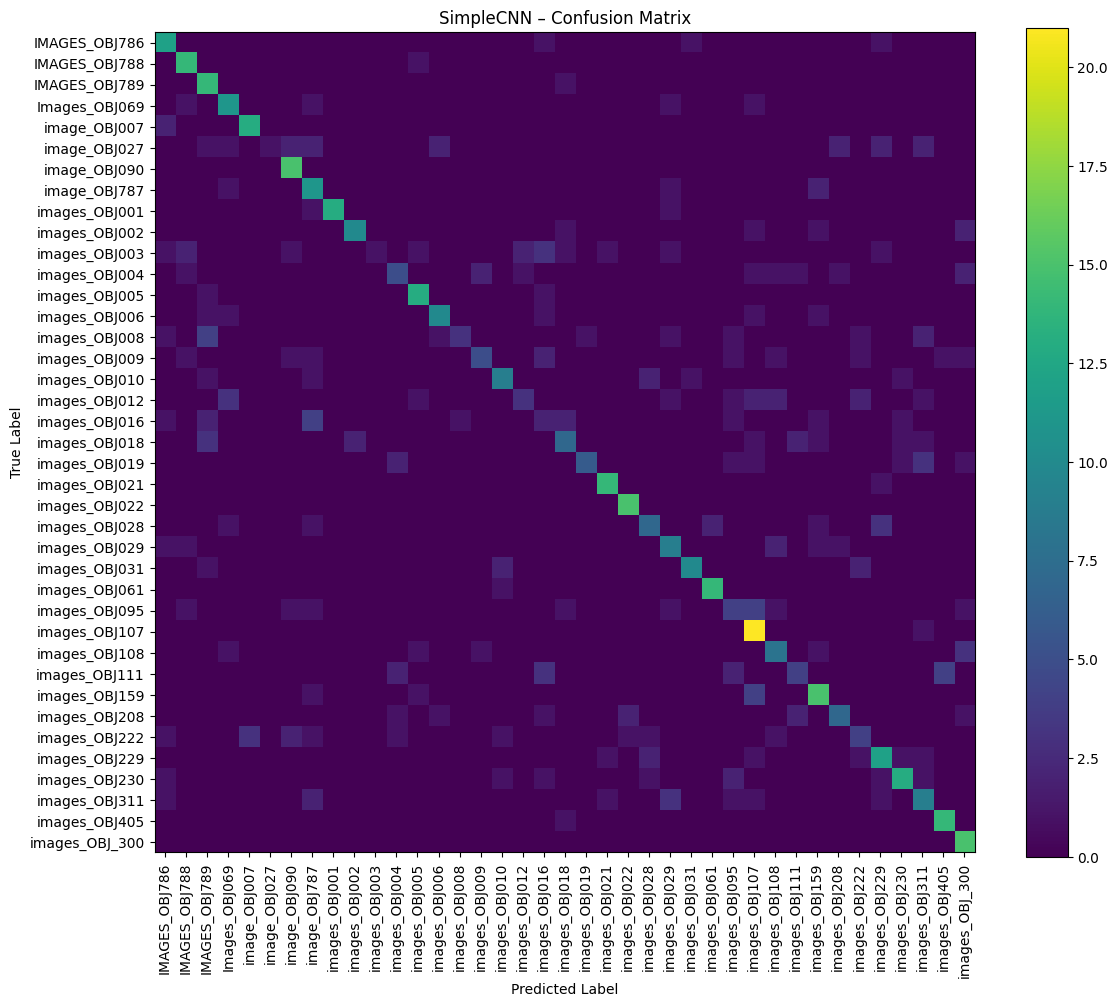


Evaluating: ResNet18
Checkpoint: /content/ResNet18_best.pt
ResNet18 | Test Accuracy = 0.9887 | Macro-F1 = 0.9884


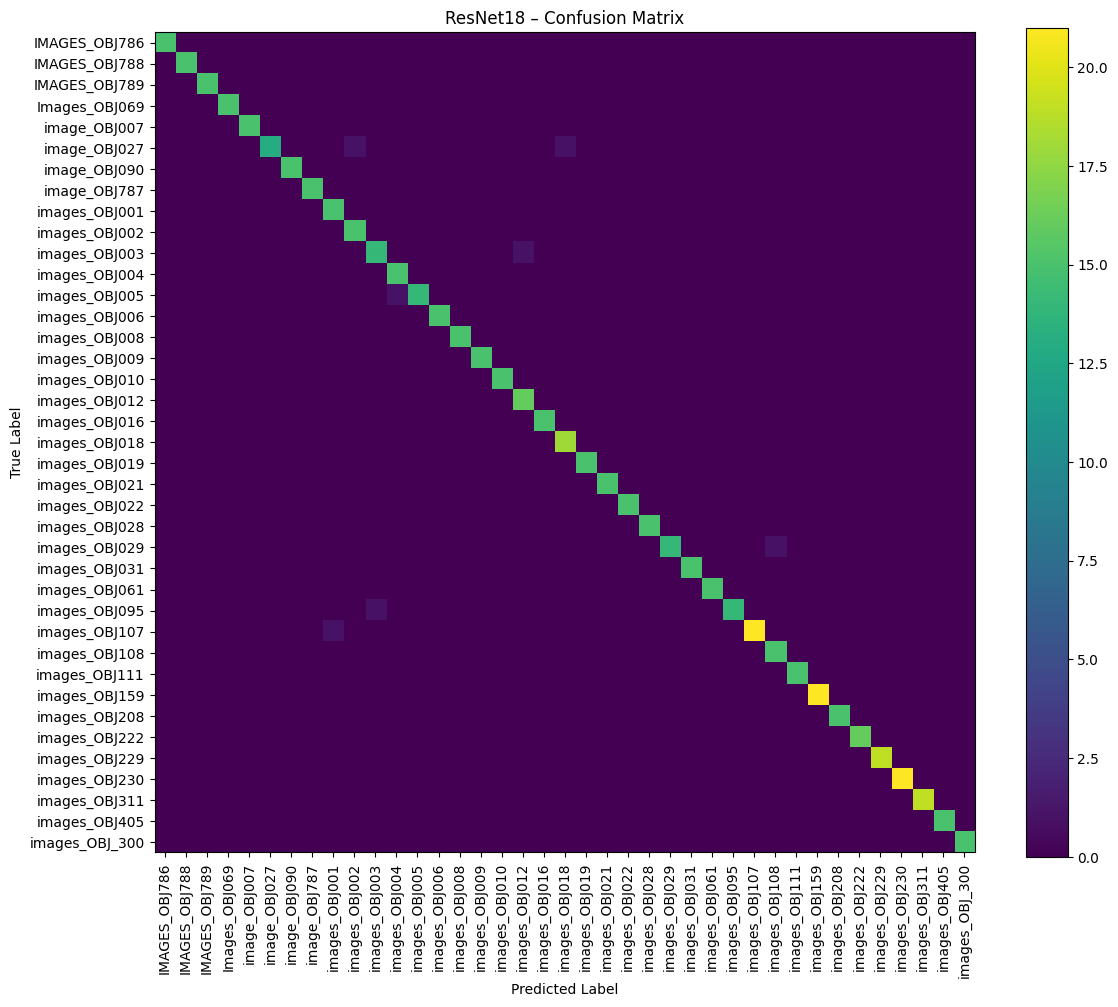


Evaluating: MobileNetV3Small
Checkpoint: /content/MobileNetV3Small_best.pt
MobileNetV3Small | Test Accuracy = 0.9676 | Macro-F1 = 0.9673


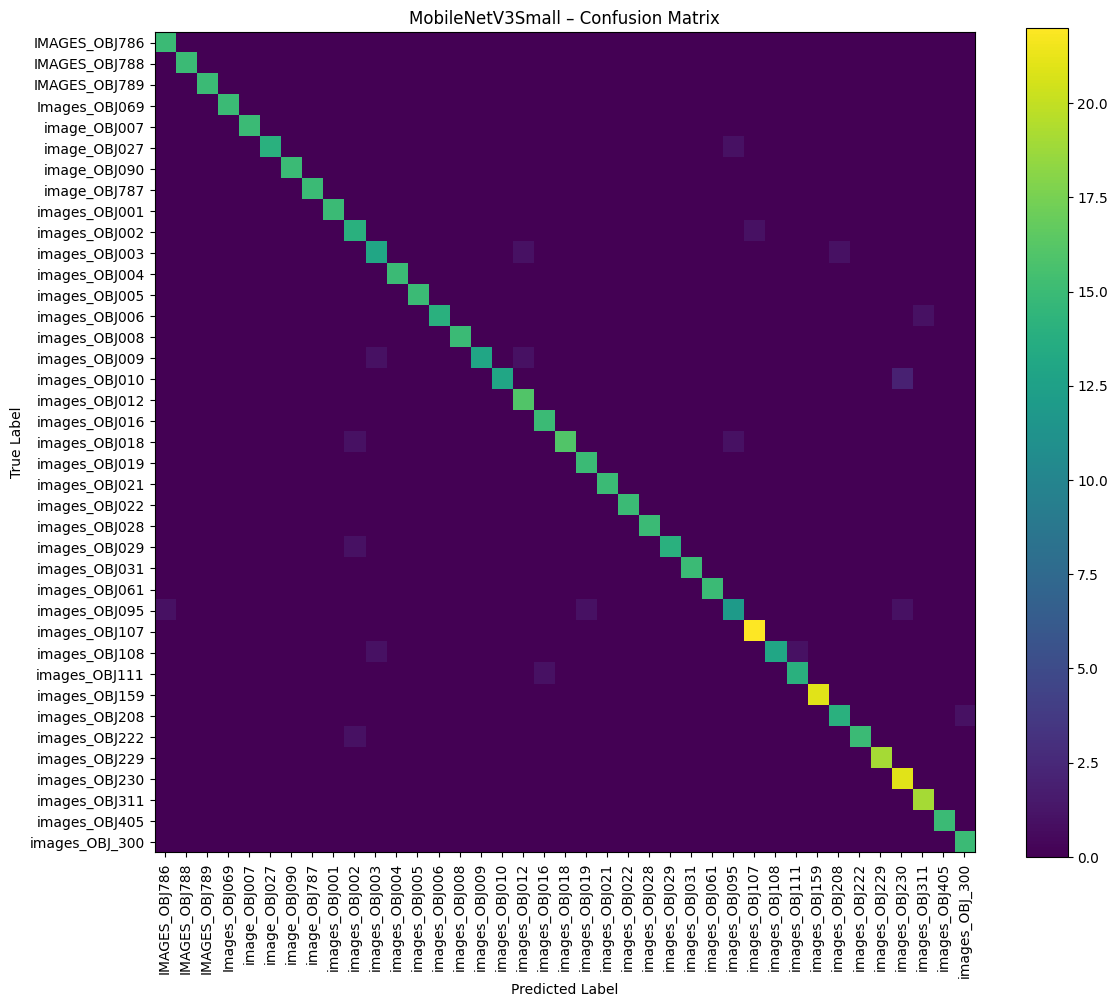

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

all_cms = {}
all_reports = {}
all_metrics = []  # (model, acc, macro_f1)

def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=90)
    plt.yticks(ticks, class_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

for (name, best_val_acc, test_acc_saved, test_f1_saved, ckpt_path) in results:
    print("\n==============================")
    print("Evaluating:", name)
    print("Checkpoint:", ckpt_path)
    print("==============================")

    model = get_model_by_name(name, num_classes)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device)
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")
    cm  = confusion_matrix(y_true, y_pred)

    rep = classification_report(y_true, y_pred, target_names=full_ds.classes)

    all_cms[name] = cm
    all_reports[name] = rep
    all_metrics.append((name, acc, f1))

    print(f"{name} | Test Accuracy = {acc:.4f} | Macro-F1 = {f1:.4f}")

    # 🔹 Show confusion matrix plot
    plot_confusion_matrix(cm, full_ds.classes, f"{name} – Confusion Matrix")

Summary plots for ALL models (Acc + Macro-F1)

In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names, title, save_path=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.title(title)
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=90)
    plt.yticks(ticks, class_names)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200)
        plt.close()
    else:
        plt.show()

for name, cm in all_cms.items():
    plot_confusion_matrix(
        cm,
        full_ds.classes,
        title=f"{name} - Confusion Matrix",
        save_path=f"/content/{name}_confusion_matrix.png"
    )
    print("Saved:", f"/content/{name}_confusion_matrix.png")

Saved: /content/SimpleCNN_confusion_matrix.png
Saved: /content/ResNet18_confusion_matrix.png
Saved: /content/MobileNetV3Small_confusion_matrix.png


Decide the best model (use Macro-F1 first)

In [ ]:
best_by_f1 = max(all_metrics, key=lambda x: x[2])  # (name, acc, f1)
best_name, best_acc, best_f1 = best_by_f1

print("Best model (by Macro-F1):", best_name)
print("Test Accuracy:", round(best_acc, 4))
print("Test Macro-F1:", round(best_f1, 4))

Best model (by Macro-F1): ResNet18
Test Accuracy: 0.9887
Test Macro-F1: 0.9884


Show classification reports for all models

In [ ]:
for name, rep in all_reports.items():
    print("\n============================")
    print("Classification report:", name)
    print("============================")
    print(rep)


Classification report: SimpleCNN
                precision    recall  f1-score   support

 IMAGES_OBJ786       0.57      0.80      0.67        15
 IMAGES_OBJ788       0.67      0.93      0.78        15
 IMAGES_OBJ789       0.50      0.93      0.65        15
 Images_OBJ069       0.58      0.73      0.65        15
  image_OBJ007       0.81      0.87      0.84        15
  image_OBJ027       1.00      0.07      0.12        15
  image_OBJ090       0.68      1.00      0.81        15
  image_OBJ787       0.41      0.73      0.52        15
 images_OBJ001       1.00      0.87      0.93        15
 images_OBJ002       0.83      0.67      0.74        15
 images_OBJ003       1.00      0.07      0.12        15
 images_OBJ004       0.45      0.33      0.38        15
 images_OBJ005       0.72      0.87      0.79        15
 images_OBJ006       0.71      0.67      0.69        15
 images_OBJ008       0.75      0.20      0.32        15
 images_OBJ009       0.62      0.33      0.43        15
 images_OBJ01

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plotting

In [3]:
models = ['SimpleCNN', 'ResNet18', 'MobileNetV3Small']

# Validation Accuracy
val_acc = [0.6201, 0.9968, 0.9724]

# Test Accuracy
test_acc = [0.6045, 0.9887, 0.9676]

# Test F1-Score
test_f1 = [0.5766, 0.9884, 0.9673]

# Color scheme
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

# Set style
sns.set_style("whitegrid")

## VALIDATION ACCURACY

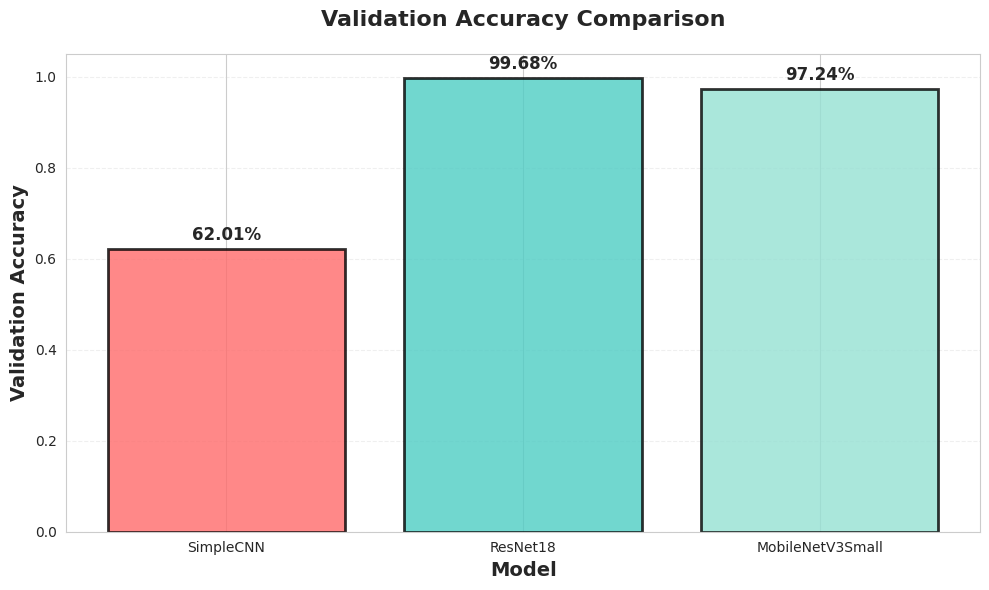

✓ Saved: plot1_validation_accuracy.png


In [4]:
plt.figure(figsize=(10, 6))
bars = plt.bar(models, val_acc, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

plt.ylabel('Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.title('Validation Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylim([0, 1.05])
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, v) in enumerate(zip(bars, val_acc)):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02,
             f'{v:.2%}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('plot1_validation_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: plot1_validation_accuracy.png")

## TEST ACCURACY

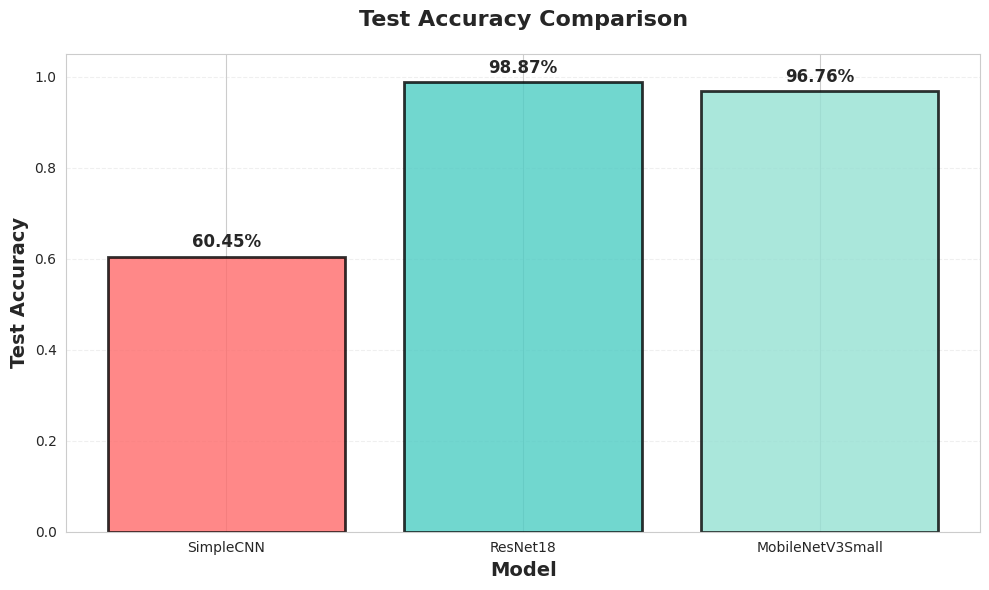

✓ Saved: plot2_test_accuracy.png


In [5]:
plt.figure(figsize=(10, 6))
bars = plt.bar(models, test_acc, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

plt.ylabel('Test Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.title('Test Accuracy Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylim([0, 1.05])
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, v) in enumerate(zip(bars, test_acc)):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02,
             f'{v:.2%}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('plot2_test_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: plot2_test_accuracy.png")

## F1-SCORE

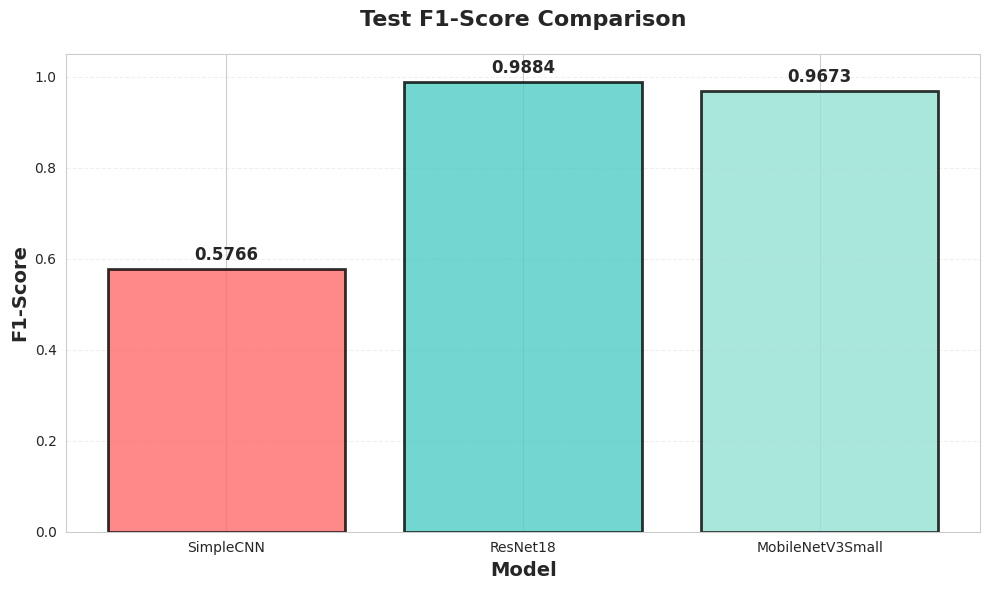

✓ Saved: plot3_f1_score.png

✅ ALL 3 PLOTS GENERATED SUCCESSFULLY!

Files saved:
1. plot1_validation_accuracy.png
2. plot2_test_accuracy.png
3. plot3_f1_score.png


In [6]:
plt.figure(figsize=(10, 6))
bars = plt.bar(models, test_f1, color=colors, edgecolor='black', linewidth=2, alpha=0.8)

plt.ylabel('F1-Score', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.title('Test F1-Score Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylim([0, 1.05])
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, v) in enumerate(zip(bars, test_f1)):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02,
             f'{v:.4f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('plot3_f1_score.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: plot3_f1_score.png")

print("\n" + "="*50)
print("✅ ALL 3 PLOTS GENERATED SUCCESSFULLY!")
print("="*50)
print("\nFiles saved:")
print("1. plot1_validation_accuracy.png")
print("2. plot2_test_accuracy.png")
print("3. plot3_f1_score.png")

# Model comparison / results summary

Comparing performance across different models.

This summary helps identify the best-performing architecture based on accuracy and F1-score.

In [ ]:
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)

print("\n===== FINAL RESULTS (sorted by TEST accuracy) =====")
for name, val_acc, test_acc, test_f1, path in results_sorted:
    print(f"{name:18s} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f} | test_f1={test_f1:.4f} | {path}")

print("\nBest model:", results_sorted[0][0])


===== FINAL RESULTS (sorted by TEST accuracy) =====
ResNet18           | val_acc=0.9968 | test_acc=0.9887 | test_f1=0.9884 | /content/ResNet18_best.pt
MobileNetV3Small   | val_acc=0.9724 | test_acc=0.9676 | test_f1=0.9673 | /content/MobileNetV3Small_best.pt
SimpleCNN          | val_acc=0.6201 | test_acc=0.6045 | test_f1=0.5766 | /content/SimpleCNN_best.pt

Best model: ResNet18
